In [ ]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-c9353785-9341-5684-5201-d6b62158ea82)


In [ ]:
!pip install -q evaluate accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import itertools

import torch
from torchvision.transforms import Compose, Normalize, Resize, ToTensor

import evaluate
from datasets import load_dataset, ClassLabel, Image
from transformers import (
    AutoImageProcessor,
    ViTForImageClassification,
    TrainingArguments,
    Trainer,
)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.10.0+cu128
CUDA available: True
GPU: NVIDIA L4


In [ ]:
dataset = load_dataset("justacoderwhocodes/dental_diagnosis_balanced_dataset", split="train")
print(f"Total samples: {len(dataset)}")
print(f"Columns: {dataset.column_names}")

README.md:   0%|          | 0.00/448 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/45.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2144 [00:00<?, ? examples/s]

Total samples: 2144
Columns: ['filename', 'tooth', 'treatment', 'diagnosis', 'text']


In [ ]:
# random.seed(42)

# labels_list = ["extraction", "none", "rct", "restoration"]
# labels_list = sorted(labels_list)

# label2id = {label: i for i, label in enumerate(labels_list)}
# id2label = {i: label for i, label in enumerate(labels_list)}

# print(f"Labels: {labels_list}")
# print(f"label2id: {label2id}")
# print(f"id2label: {id2label}")

# dataset = dataset.filter(lambda x: x['treatment'] != 'replacement')
# print(f"\nDataset size after removing 'replacement': {len(dataset)}")

# print(f"\nOriginal distribution:")
# treatments = dataset['treatment']
# for t in labels_list:
#     count = treatments.count(t)
#     print(f"  {t}: {count}")

# none_indices = [i for i, t in enumerate(treatments) if t == 'none']
# other_indices = [i for i, t in enumerate(treatments) if t != 'none']

# sampled_none = random.sample(none_indices, min(400, len(none_indices)))
# balanced_indices = sorted(sampled_none + other_indices)
# dataset = dataset.select(balanced_indices)

# print(f"\nAfter balancing (none -> 400):")
# treatments = dataset['treatment']
# for t in labels_list:
#     count = treatments.count(t)
#     print(f"  {t}: {count}")
# print(f"\nTotal samples: {len(dataset)}")

# ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# def map_treatment_to_label(example):
#     example['label'] = label2id[example['treatment']]
#     return example

# dataset = dataset.map(map_treatment_to_label)
# dataset = dataset.cast_column('label', ClassLabels)

# dataset = dataset.train_test_split(test_size=0.1, seed=42, stratify_by_column="label")

# train_data = dataset['train']
# test_data = dataset['test']

# print(f"\nTrain: {len(train_data)} samples")
# print(f"Test: {len(test_data)} samples")

In [ ]:
import random
random.seed(42)

labels_list = ["none", "treatment"]
label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}
print(f"Labels: {labels_list}")
print(f"label2id: {label2id}")
print(f"id2label: {id2label}")
dataset = dataset.filter(lambda x: x['treatment'] != 'replacement')
print(f"\nDataset size after removing 'replacement': {len(dataset)}")
def map_to_binary(example):
    if example['treatment'] == 'none':
        example['binary_label'] = 'none'
    else:
        example['binary_label'] = 'treatment'
    return example
dataset = dataset.map(map_to_binary)
print(f"\nOriginal binary distribution:")
binary_labels = dataset['binary_label']
for t in labels_list:
    count = binary_labels.count(t)
    print(f"  {t}: {count}")
# Undersample none to 400, keep all treatment
none_indices = [i for i, label in enumerate(binary_labels) if label == 'none']
treatment_indices = [i for i, label in enumerate(binary_labels) if label == 'treatment']
sampled_none = random.sample(none_indices, min(400, len(none_indices)))
balanced_indices = sorted(sampled_none + treatment_indices)
dataset = dataset.select(balanced_indices)
print(f"\nAfter balancing (none -> 400, treatment -> all):")

binary_labels = dataset['binary_label']
for t in labels_list:
    count = binary_labels.count(t)
    print(f"  {t}: {count}")
print(f"\nTotal samples: {len(dataset)}")
ClassLabels = ClassLabel(num_classes=2, names=labels_list)
def map_label(example):
    example['label'] = label2id[example['binary_label']]
    return example
dataset = dataset.map(map_label)
dataset = dataset.cast_column('label', ClassLabels)
dataset = dataset.train_test_split(test_size=0.1, seed=42, stratify_by_column="label")
train_data = dataset['train']
test_data = dataset['test']
print(f"\nTrain: {len(train_data)} samples")
print(f"Test: {len(test_data)} samples")

Labels: ['none', 'treatment']
label2id: {'none': 0, 'treatment': 1}
id2label: {0: 'none', 1: 'treatment'}


Filter:   0%|          | 0/2144 [00:00<?, ? examples/s]


Dataset size after removing 'replacement': 2142


Map:   0%|          | 0/2142 [00:00<?, ? examples/s]


Original binary distribution:
  none: 1072
  treatment: 1070

After balancing (none -> 400, treatment -> all):
  none: 400
  treatment: 1070

Total samples: 1470


Map:   0%|          | 0/1470 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1470 [00:00<?, ? examples/s]


Train: 1323 samples
Test: 147 samples


In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_str = "facebook/convnextv2-base-22k-224"
# model_str = "google/medsiglip-448"

processor = AutoImageProcessor.from_pretrained(model_str)

model = AutoModelForImageClassification.from_pretrained(
    model_str,
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

print(f"Model: {model_str}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

The image processor of type `ConvNextImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

ConvNextV2ForImageClassification LOAD REPORT from: facebook/convnextv2-base-22k-224
Key               | Status   |                                                                                          
------------------+----------+------------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([2])            
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 1024]) vs model:torch.Size([2, 1024])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


Model: facebook/convnextv2-base-22k-224
Trainable parameters: 87,694,850


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomRotation, RandomHorizontalFlip, ColorJitter
from datasets import Image

# Get processor stats
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size.get("height", 224)
print(f"Image size: {size}x{size}")

train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(degrees=15),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

train_data = train_data.cast_column('filename', Image())
test_data = test_data.cast_column('filename', Image())

def train_transforms_fn(examples):
    examples['pixel_values'] = [train_transforms(img.convert("RGB")) for img in examples['filename']]
    return examples

def val_transforms_fn(examples):
    examples['pixel_values'] = [val_transforms(img.convert("RGB")) for img in examples['filename']]
    return examples

train_data = train_data.with_transform(train_transforms_fn)
test_data = test_data.with_transform(val_transforms_fn)

print("Transforms applied! Training set is now augmented on-the-fly.")

Image size: 224x224
Transforms applied! Training set is now augmented on-the-fly.


In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

In [ ]:
args = TrainingArguments(
    output_dir="./vit-dental-treatment",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=7e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    remove_unused_columns=False,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    bf16=True,
    report_to="none",
    push_to_hub=True,
    hub_model_id="justacoderwhocodes/dental-iopar-binary-classifier"
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    # tokenizer=processor,
)

# class LabelSmoothingTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
#         labels = inputs.get("labels")
#         outputs = model(**inputs)
#         logits = outputs.get("logits")

#         loss_fct = torch.nn.CrossEntropyLoss(label_smoothing=0.05)
#         loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

#         return (loss, outputs) if return_outputs else loss

# trainer = LabelSmoothingTrainer(
#     model,
#     args,
#     train_dataset=train_data,
#     eval_dataset=test_data,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     # tokenizer=processor,
# )

print("Trainer initialized. Starting training...")

Trainer initialized. Starting training...


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.542316,0.461173,0.823129,0.713235
2,0.482282,0.394714,0.829932,0.763285
3,0.398184,0.426624,0.829932,0.776256
4,0.293237,0.377334,0.836735,0.802773
5,0.212415,0.328861,0.870748,0.823596
6,0.138663,0.442382,0.911565,0.881547
7,0.070407,0.583779,0.863946,0.830879
8,0.045351,0.565411,0.891156,0.855528
9,0.023317,0.556750,0.884354,0.845100
10,0.009918,0.571499,0.891156,0.852853


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=830, training_loss=0.22160904170518897, metrics={'train_runtime': 329.318, 'train_samples_per_second': 40.174, 'train_steps_per_second': 2.52, 'total_flos': 1.047858101627904e+18, 'train_loss': 0.22160904170518897, 'epoch': 10.0})

In [ ]:
outputs = trainer.predict(test_data)
print(f"\nFinal metrics: {outputs.metrics}")

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro: {f1_score(y_true, y_pred, average='macro'):.4f}")


Final metrics: {'test_loss': 0.44238224625587463, 'test_accuracy': 0.9115646258503401, 'test_f1_macro': 0.8815471394037067, 'test_runtime': 1.0291, 'test_samples_per_second': 142.849, 'test_steps_per_second': 18.464}

Accuracy: 0.9116
F1 Macro: 0.8815


In [ ]:
test_model = AutoModelForImageClassification.from_pretrained(
    "justacoderwhocodes/dental-iopar-binary-classifier",
    num_labels=len(labels_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

test_model = test_model.to(torch.bfloat16).cuda()

Loading weights:   0%|          | 0/380 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

test_model.eval()

test_loader = DataLoader(test_data, batch_size=16,collate_fn=collate_fn)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(torch.bfloat16).cuda()
        labels = batch["labels"].cuda()

        outputs = test_model(pixel_values=pixel_values)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

y_true = np.array(all_labels)
y_pred = np.array(all_preds)

print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Macro: {f1_score(y_true, y_pred, average='macro'):.4f}")


Accuracy: 0.9116
F1 Macro: 0.8815


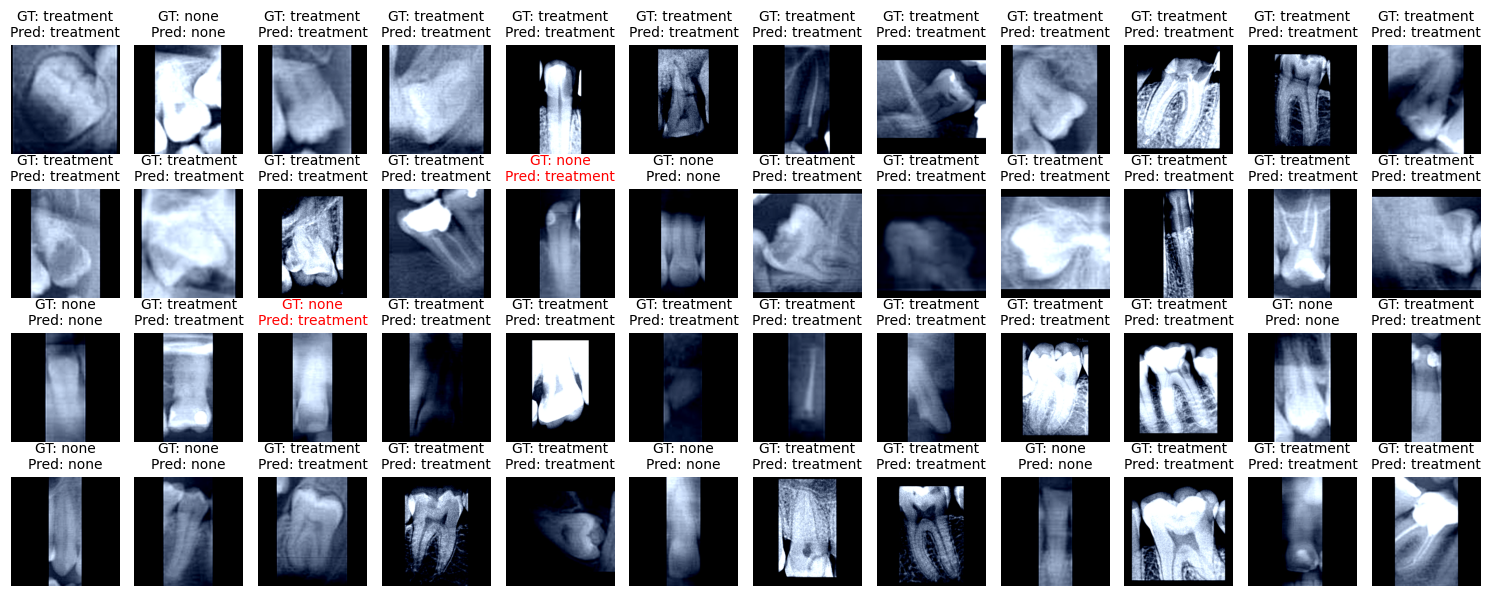

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

num_samples = 48
sample_indices = list(range(num_samples))
samples = test_data.select(sample_indices)

test_model.eval()  # make sure in eval mode
pixel_values = torch.stack([x["pixel_values"] for x in samples])

with torch.no_grad():
    outputs = test_model(pixel_values.cuda().to(torch.bfloat16))
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1).cpu().numpy()

to_pil = ToPILImage()
fig, axes = plt.subplots(4, num_samples//4, figsize=(15,6))

for i, ax in enumerate(axes.flatten()):
    # Convert tensor to PIL image
    img = to_pil(samples[i]["pixel_values"].clamp(-1,1).add(1).div(2))

    # Get labels
    gt_label = id2label[samples[i]["label"]]
    pred_label = id2label[int(preds[i])]

    # Set title color: red if mismatch, black otherwise
    title_color = "red" if gt_label != pred_label else "black"

    ax.imshow(img)
    ax.set_title(f"GT: {gt_label}\nPred: {pred_label}", fontsize=10, color=title_color)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
trainer.push_to_hub()
processor.push_to_hub("justacoderwhocodes/dental-iopar-binary-classifier")

print("\n" + "="*50)
print("Model pushed to HuggingFace!")
print("="*50)
print(f"\nRepo: https://huggingface.co/justacoderwhocodes/dental-iopar-binary-classifier")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...eatment/training_args.bin: 100%|##########| 5.26kB / 5.26kB            

  ...eatment/model.safetensors:  12%|#1        | 41.9MB /  351MB            

README.md: 0.00B [00:00, ?B/s]


Model pushed to HuggingFace!

Repo: https://huggingface.co/justacoderwhocodes/dental-iopar-binary-classifier
